In [1]:
# Code for the entire (ForestCLAM) Forest_CNN_LSTM_Attention Model

# Contains full workflow from loading/downloading data, splitting data,
# full CLAM and RandomForest model definition, Train/Evaluation setup for CLAM
# and RandomForest, training loop, evaluation for CLAM and RandomForest model,
# plot summary of prediction accuracy for CLAM and RandomForest models,
# and model performance in Simulation Stock Market for CLAM, RandomForest, and
# the final hybrid model ForestCLAM.

# Rememeber to Load checkpoint named "ForestCLAM_CLAM.pth" into your drive,
# as well as changing the path of the .pth file if needed in CLAM.5. and CLAM.6.
# to load or update the checkpoint.

# By running cell CLAM.1., the five csv data for AAPL, AMZN, GOOG, META, MSFT
# will be automatically collected and saved to your drive if you haven't copied
# the data from our github page in the directory "Data_for_Forest_CLAM"

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torch
import torch.nn as nn
from IPython.display import display

In [3]:
# CLAM.1. Download & Merge Multiple Tickers with Technical Indicators

def load_ticker_windows(ticker, seq_len=30):
    file_path = f"{ticker}_daily_2018-2025.csv"

    if not os.path.exists(file_path):
        print(f"Downloading {ticker} data...")
        df = yf.download(
            ticker,
            start="2018-01-01",
            end="2025-06-30",
            interval="1d",
            auto_adjust=True)
        df.to_csv(file_path)
    else:
        print(f"Loading cached {ticker} data from {file_path}")
        df = pd.read_csv(file_path, index_col=0)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)
    df['Close'] = df['Close'].astype(float)
    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['BB_MID'] = df['Close'].rolling(20).mean()
    df['BB_STD'] = df['Close'].rolling(20).std()
    df['BB_UP'] = df['BB_MID'] + 2 * df['BB_STD']
    df['BB_DOWN'] = df['BB_MID'] - 2 * df['BB_STD']
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    df.dropna(inplace=True)

    future_ret = df['log_ret'].rolling(5).sum().shift(-5)
    df['target'] = (future_ret > 0).astype(int)
    directions = df['target'].values
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
                'BB_UP', 'BB_DOWN', 'ATR']

    mats, y, dates = [], [], []
    for i in range(seq_len, len(df)):
        mat = df.iloc[i-seq_len:i][features].values
        norm = (mat - mat.mean(axis=0)) / mat.std(axis=0)
        mats.append(norm.T)
        y.append(directions[i])
        dates.append(df.index[i])
    return np.stack(mats), np.array(y), df.iloc[seq_len:].reset_index()

X_all, y_all, df_all_list = [], [], []
for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", "META"]:
    X, y, df = load_ticker_windows(ticker)
    X_all.append(X)
    y_all.append(y)
    df_all_list.append(df)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)
df_all = pd.concat(df_all_list).reset_index(drop=True)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [4]:
# CLAM.2. Splitting Dataset & DataLoader def

X_train, X_temp, y_train, y_temp = train_test_split(X_all,
                                                    y_all,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=42)

class ChartDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

class_counts = np.bincount(y_train)
weights = 1. / class_counts
sample_weights = weights[y_train]
sampler = WeightedRandomSampler(sample_weights,
                                len(sample_weights),
                                replacement=True)

train_loader = DataLoader(ChartDataset(X_train, y_train),
                          batch_size=64, sampler=sampler)
val_loader   = DataLoader(ChartDataset(X_val, y_val), batch_size=64)
test_loader  = DataLoader(ChartDataset(X_test, y_test), batch_size=64)

In [5]:
# CLAM.3. CLAM Model Definition

class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Linear(dim, 1)
    def forward(self, H):
        w = torch.softmax(self.attn(H).squeeze(-1), dim=1)
        return torch.bmm(w.unsqueeze(1), H).squeeze(1)

class CNN_LSTM_Attn(nn.Module):
    def __init__(self, seq_len=30, in_channels=10, cnn_dims=[32,64],
                 lstm_hidden=128):
        super().__init__()
        layers = []
        ch = in_channels
        for c in cnn_dims:
            layers += [nn.Conv1d(ch, c, kernel_size=3, padding=1), nn.ReLU(),
                       nn.MaxPool1d(2)]
            ch = c
        self.cnn = nn.Sequential(*layers)

        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, seq_len)
            cnn_out = self.cnn(dummy)
            lstm_input_dim = cnn_out.shape[1]

        self.lstm = nn.LSTM(
            input_size=lstm_input_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )
        self.attn = Attention(lstm_hidden * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc   = nn.Linear(lstm_hidden * 2, 2)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        H, _ = self.lstm(x)
        c = self.attn(H)
        return self.fc(self.dropout(c))

In [6]:
# CLAM.4. Train & Evaluation Setup for CLAM

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_LSTM_Attn().to(device)

class_wts = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y_train)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_wts, dtype=torch.float32).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

def smooth_labels(y, smoothing=0.1):
    y_onehot = torch.zeros((y.size(0), 2)).to(y.device)
    y_onehot.scatter_(1, y.unsqueeze(1), 1)
    y_smooth = y_onehot * (1 - smoothing) + (smoothing / 2)
    return y_smooth

def run_epoch(loader, train=False):
    model.train() if train else model.eval()
    total_loss, correct, total = 0, 0, 0
    all_pred, all_true = [], []
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        if train: optimizer.zero_grad()
        logits = model(Xb)
        if train:
            targets = smooth_labels(yb, 0.1)
            probs = torch.log_softmax(logits, dim=1)
            loss = torch.nn.KLDivLoss(reduction='batchmean')(probs, targets)
        else:
            loss = criterion(logits, yb)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * Xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += Xb.size(0)
        all_pred.extend(preds.cpu().numpy())
        all_true.extend(yb.cpu().numpy())
    return total_loss / total, correct / total, all_true, all_pred

In [7]:
# CLAM.5. Training Loop for CLAM

DO_TRAINING = False
if DO_TRAINING:
    best, wait = float('inf'), 0
    PATIENCE = 20
    for ep in range(1, 100):
        tr_l, tr_a, _, _ = run_epoch(train_loader, train=True)
        v_l, v_a, _, _ = run_epoch(val_loader, train=False)
        scheduler.step(v_l)
        print(f"Epoch {ep:02d} — Train loss {tr_l:.4f}, acc {tr_a:.3f}; Val loss {v_l:.4f}, acc {v_a:.3f}")
        if v_l < best:
            torch.save(model.state_dict(), 'ForestCLAM_CLAM.pth')
            best, wait = v_l, 0
        else:
            wait += 1
            if wait >= PATIENCE:
                print("Early stopping")
                break
else:
    print("Skipping training phase...")

Skipping training phase...


In [8]:
# CLAM.6. CLAM Model Evaluation

model.load_state_dict(torch.load('ForestCLAM_CLAM.pth'))
t_l, t_a, y_true, y_pred = run_epoch(test_loader, train=False)
print(f"Test loss {t_l:.4f}, Test acc {t_a:.3f}")

for name, y in zip(["Train", "Val", "Test"], [y_train, y_val, y_test]):
    counts = np.bincount(y)
    print(f"{name} - Up: {counts[1]/sum(counts):.2f}, Down: {counts[0]/sum(counts):.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Down', 'Up']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Test loss 0.5803, Test acc 0.712
Train - Up: 0.56, Down: 0.44
Val - Up: 0.58, Down: 0.42
Test - Up: 0.60, Down: 0.40

Classification Report:
              precision    recall  f1-score   support

        Down       0.64      0.64      0.64       364
          Up       0.76      0.76      0.76       553

    accuracy                           0.71       917
   macro avg       0.70      0.70      0.70       917
weighted avg       0.71      0.71      0.71       917

Confusion Matrix:
[[233 131]
 [133 420]]


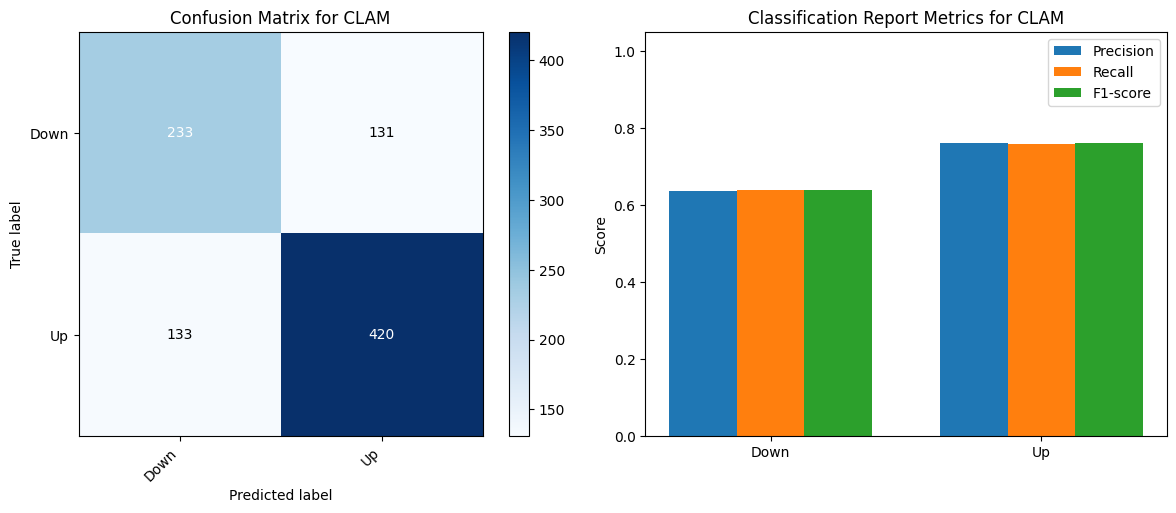

In [9]:
# CLAM.7. Visualization of Confustion Matrix & Classification Report for CLAM

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

labels    = ['Down', 'Up']
cr_dict   = classification_report(
    y_true, y_pred,
    target_names=labels,
    output_dict=True
)
precision = [cr_dict[l]['precision'] for l in labels]
recall    = [cr_dict[l]['recall']    for l in labels]
f1        = [cr_dict[l]['f1-score']  for l in labels]
cm        = confusion_matrix(y_true, y_pred)

fig, (ax_cm, ax_bar) = plt.subplots(1, 2, figsize=(12, 5))

im = ax_cm.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(im, ax=ax_cm)
ax_cm.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix for CLAM'
)
plt.setp(ax_cm.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax_cm.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

x     = np.arange(len(labels))
width = 0.25

ax_bar.bar(x - width, precision, width, label='Precision')
ax_bar.bar(x,        recall,    width, label='Recall')
ax_bar.bar(x + width, f1,       width, label='F1-score')

ax_bar.set(
    xticks=x,
    xticklabels=labels,
    ylabel='Score',
    title='Classification Report Metrics for CLAM'
)
ax_bar.legend(loc='best')
ax_bar.set_ylim(0, 1.05)

fig.tight_layout()
plt.show()

Baseline: Buy-and-Hold Stock Performance
Starting capital:     $ 1,000,000.00
Ending capital:       $ 2,279,737.72
Total 1,279,737.72
Percentage growth:    127.97%

Confidence threshold: 0.5
Starting capital: $ 1,000,000.00
Ending capital:   $ 2,586,964.09
Net P/L:          $ 1,586,964.09

Confidence threshold: 0.6
Starting capital: $ 1,000,000.00
Ending capital:   $ 2,023,506.35
Net P/L:          $ 1,023,506.35

Confidence threshold: 0.7
Starting capital: $ 1,000,000.00
Ending capital:   $ 1,386,227.43
Net P/L:          $ 386,227.43

Confidence threshold: 0.8
Starting capital: $ 1,000,000.00
Ending capital:   $ 1,449,007.81
Net P/L:          $ 449,007.81

Confidence threshold: 0.9
Starting capital: $ 1,000,000.00
Ending capital:   $ 1,270,023.90
Net P/L:          $ 270,023.90

Confidence threshold: 0.95
Starting capital: $ 1,000,000.00
Ending capital:   $ 1,312,312.01
Net P/L:          $ 312,312.01



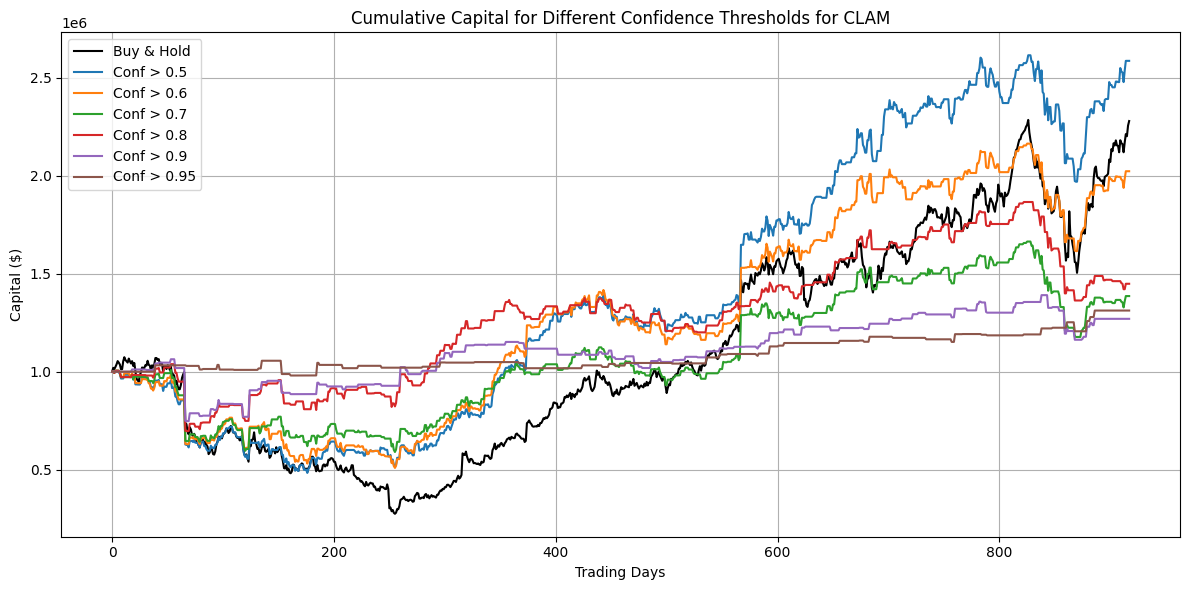

In [10]:
# CLAM.8. Hypothetical Stock Market, with 1_000_000 Initial Capital

initial_capital = 1_000_000.0
all_logits = []
model.eval()
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        all_logits.append(logits.cpu())
logits_all = torch.cat(all_logits, dim=0)
probs_cla = torch.softmax(logits_all, dim=1)
confidences, y_pred_conf = probs_cla.max(dim=1)

returns = np.exp(df_all['log_ret'].values) - 1
test_returns = returns[-len(y_pred_conf):]
confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
plt.figure(figsize=(12, 6))
stock_capital = initial_capital
stock_curve = [stock_capital]

for ret in test_returns:
    stock_capital *= (1 + ret)
    stock_curve.append(stock_capital)

stock_growth = stock_capital - initial_capital
stock_pct_growth = (stock_capital / initial_capital - 1) * 100

print("Baseline: Buy-and-Hold Stock Performance")
print(f"Starting capital:     $ {initial_capital:,.2f}")
print(f"Ending capital:       $ {stock_capital:,.2f}")
print(f"Total {stock_growth:,.2f}")
print(f"Percentage growth:    {stock_pct_growth:.2f}%\n")

plt.plot(stock_curve, label="Buy & Hold", color="black")

for CONF_THRESH in confidence_thresholds:
    capital = initial_capital
    capital_curve = [capital]

    for ret, pred, conf in zip(test_returns, y_pred_conf, confidences):
        if pred == 1 and conf > CONF_THRESH:
            capital *= (1 + ret)
        capital_curve.append(capital)

    print(f"Confidence threshold: {CONF_THRESH}")
    print(f"Starting capital: $ {initial_capital:,.2f}")
    print(f"Ending capital:   $ {capital:,.2f}")
    print(f"Net P/L:          $ {capital - initial_capital:,.2f}\n")

    plt.plot(capital_curve, label=f"Conf > {CONF_THRESH}")

plt.title("Cumulative Capital for Different Confidence Thresholds for CLAM")
plt.xlabel("Trading Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# RandomForest.1. func to load ticker data

def load_ticker_windows(ticker, seq_len=30):
    file_path = f"content/{ticker}_daily_2018-2025.csv" # change if needed
    if not os.path.exists('content'):
        os.makedirs('content')
    if not os.path.exists(file_path):
        df = yf.download(ticker, start="2018-01-01", end="2025-06-30",
                        interval="1d", auto_adjust=True) # date range over a day
        df.to_csv(file_path)
    else:
        df = pd.read_csv(file_path, index_col=0) # read if df already exsists

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # OHLCV data
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))# other measures

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['BB_MID'] = df['Close'].rolling(20).mean()
    df['BB_STD'] = df['Close'].rolling(20).std()
    df['BB_UP'] = df['BB_MID'] + 2 * df['BB_STD']
    df['BB_DOWN'] = df['BB_MID'] - 2 * df['BB_STD']
    df['ATR'] = (df['High'] - df['Low']).rolling(14).mean()

    df.dropna(inplace=True) # drop bad data

    future_ret = df['log_ret'].rolling(5).sum().shift(-5)
    df['target'] = (future_ret > 0).astype(int) # buy if future return is +

    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'BB_UP', 'BB_DOWN', 'ATR']
    mats, y, dates = [], [], []

    for i in range(seq_len, len(df)):
        mat = df.iloc[i-seq_len:i][features].values
        # no normalization, just flatten
        mats.append(mat.T.flatten())
        y.append(df['target'].iloc[i])
        dates.append(df.index[i])

    return np.stack(mats), np.array(y), df.iloc[seq_len:].reset_index()

In [12]:
# RandomForest.2. Load all tickers

X_all, y_all, df_all_list = [], [], []
for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", "META"]:
    X, y, df = load_ticker_windows(ticker)
    X_all.append(X)
    y_all.append(y)
    df_all_list.append(df)

X_all = np.concatenate(X_all) # combine all info
y_all = np.concatenate(y_all)
df_all = pd.concat(df_all_list).reset_index(drop=True) # again drop bad data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
# RandomForest.3. split data, suffle, stratify

X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2,
                                  random_state=42, stratify=y_all, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                random_state=42, stratify=y_temp, shuffle=True)

In [14]:
# RandomForest.4. init Random Forest without normalization and train

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
#takes ~1 min

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

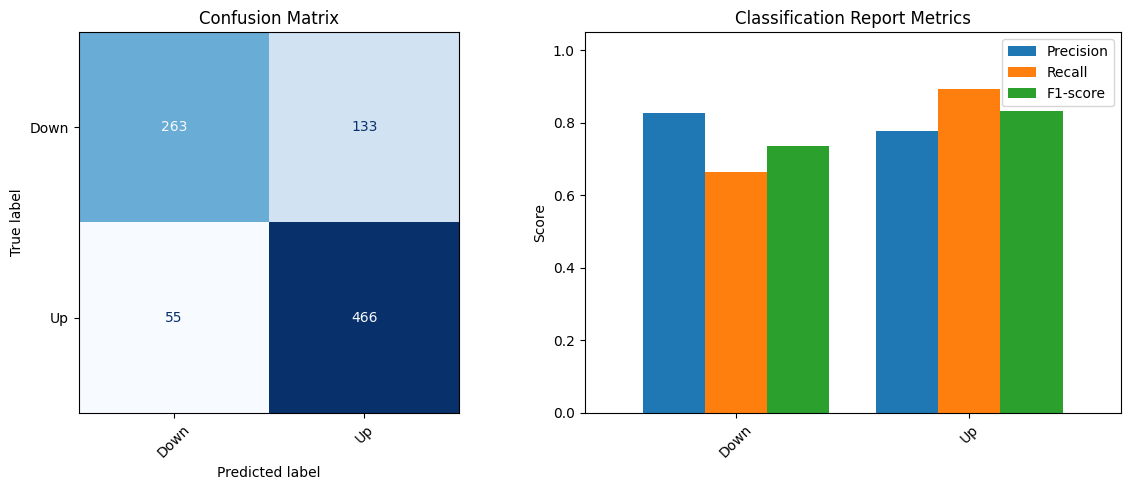

In [15]:
# RandomForest.5. evaluate the forest results by getting classification report

y_pred = rf.predict(X_test) # get predictions
cr_dict = classification_report(y_test, y_pred, target_names=['Down', 'Up'], output_dict=True)

# calc common eval scores
labels = ['Down', 'Up']
precision = [cr_dict[l]['precision'] for l in labels]
recall = [cr_dict[l]['recall'] for l in labels]
f1 = [cr_dict[l]['f1-score'] for l in labels]

# get cm
cm = confusion_matrix(y_test, y_pred)

# display cm
fig, (ax_cm, ax_bar) = plt.subplots(1, 2, figsize=(12, 5)) # makes subplots
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(
    cmap="Blues", xticks_rotation=45, ax=ax_cm, colorbar=False
)
ax_cm.set_title("Confusion Matrix")

# make the classification scores a chart
df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}, index=labels)
df.plot(kind='bar', ylim=(0, 1.05), ax=ax_bar, width=0.8)
ax_bar.set_ylabel('Score')
ax_bar.set_title('Classification Report Metrics')
ax_bar.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

=== Buy-Hold Performance ===
Starting capital: $1,000,000.00
Ending capital: $2,279,737.72
Total 1,279,737.72
Percentage growth: 127.97%

=== Profit vs Confidence ===
Threshold: 0.50 | Final: $1,500,306.68 | Net P/L: $500,306.68 | Trades: 599 | Avg Gain: 0.0189 | Avg Loss: -0.0188
Threshold: 0.60 | Final: $1,092,324.02 | Net P/L: $92,324.02 | Trades: 447 | Avg Gain: 0.0185 | Avg Loss: -0.0196
Threshold: 0.70 | Final: $1,039,301.45 | Net P/L: $39,301.45 | Trades: 294 | Avg Gain: 0.0186 | Avg Loss: -0.0187
Threshold: 0.80 | Final: $888,037.21 | Net P/L: $-111,962.79 | Trades: 109 | Avg Gain: 0.0216 | Avg Loss: -0.0218
Threshold: 0.85 | Final: $829,589.56 | Net P/L: $-170,410.44 | Trades: 49 | Avg Gain: 0.0191 | Avg Loss: -0.0251
Threshold: 0.90 | Final: $760,405.87 | Net P/L: $-239,594.13 | Trades: 13 | Avg Gain: 0.0133 | Avg Loss: -0.0451
Threshold: 0.95 | Final: $960,926.07 | Net P/L: $-39,073.93 | Trades: 2 | Avg Gain: 0.0000 | Avg Loss: -0.0197


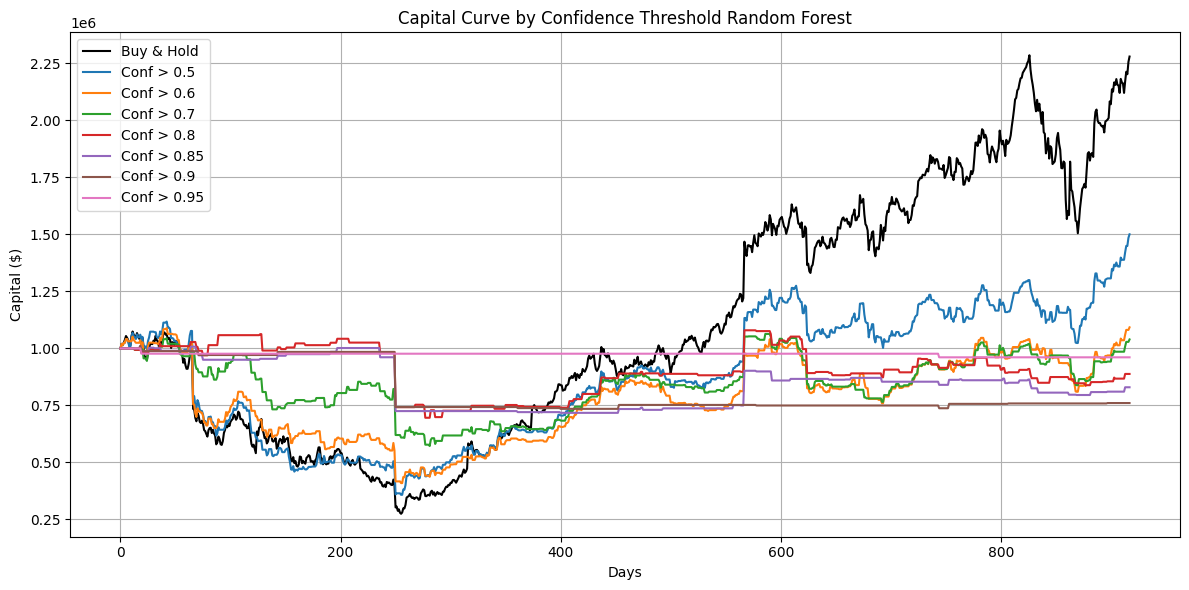

In [16]:
# RandomForest.6. Stock Market Simulation

# setup simulated marked
probs = rf.predict_proba(X_test) # this function predicts buy/sell with probability, allows for confidence score to be implemented
confidences = np.max(probs, axis=1)
y_pred_conf = np.argmax(probs, axis=1)

# get retruns
returns = np.exp(df_all['log_ret'].values) - 1
test_returns = returns[-len(y_pred_conf):]
initial_capital = 1000000.0


# calc buy-and-hold info
stock_capital = initial_capital
stock_curve = [stock_capital]

for ret in test_returns:
    stock_capital *= (1 + ret)
    stock_curve.append(stock_capital)

stock_growth = stock_capital - initial_capital
stock_pct_growth = (stock_capital / initial_capital - 1) * 100

# print buy-hold results
print("=== Buy-Hold Performance ===")
print(f"Starting capital: ${initial_capital:,.2f}")
print(f"Ending capital: ${stock_capital:,.2f}")
print(f"Total {stock_growth:,.2f}")
print(f"Percentage growth: {stock_pct_growth:.2f}%\n")

# add to plt
plt.figure(figsize=(12, 6))
plt.plot(stock_curve, label="Buy & Hold", linestyle="-", color="black")

# determine trades and money made based on confidence thresh
thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]
results = []

for thresh in thresholds:
    capital = initial_capital
    capital_curve = [capital]
    trade_count = 0
    profit_trades, loss_trades = [], []

    # determines the trades made and return
    for ret, pred, conf in zip(test_returns, y_pred_conf, confidences):
        if pred == 1 and conf > thresh:
            trade_count += 1
            capital *= (1 + ret)
            (profit_trades if ret >= 0 else loss_trades).append(ret)
        capital_curve.append(capital)

    results.append({
        'threshold': thresh,
        'final_capital': capital,
        'net_PL': capital - initial_capital,
        'total_trades': trade_count,
        'avg_gain': np.mean(profit_trades) if profit_trades else 0,
        'avg_loss': np.mean(loss_trades) if loss_trades else 0,
    })

    # add to plt
    plt.plot(capital_curve, label=f"Conf > {thresh}")

# print results
print("=== Profit vs Confidence ===")
for r in results:
    print(f"Threshold: {r['threshold']:.2f} | Final: ${r['final_capital']:,.2f} | "
          f"Net P/L: ${r['net_PL']:,.2f} | Trades: {r['total_trades']} | "
          f"Avg Gain: {r['avg_gain']:.4f} | Avg Loss: {r['avg_loss']:.4f}")

# plot
plt.title("Capital Curve by Confidence Threshold Random Forest")
plt.xlabel("Days")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Best L/S Ensemble → Final = $2,922,366


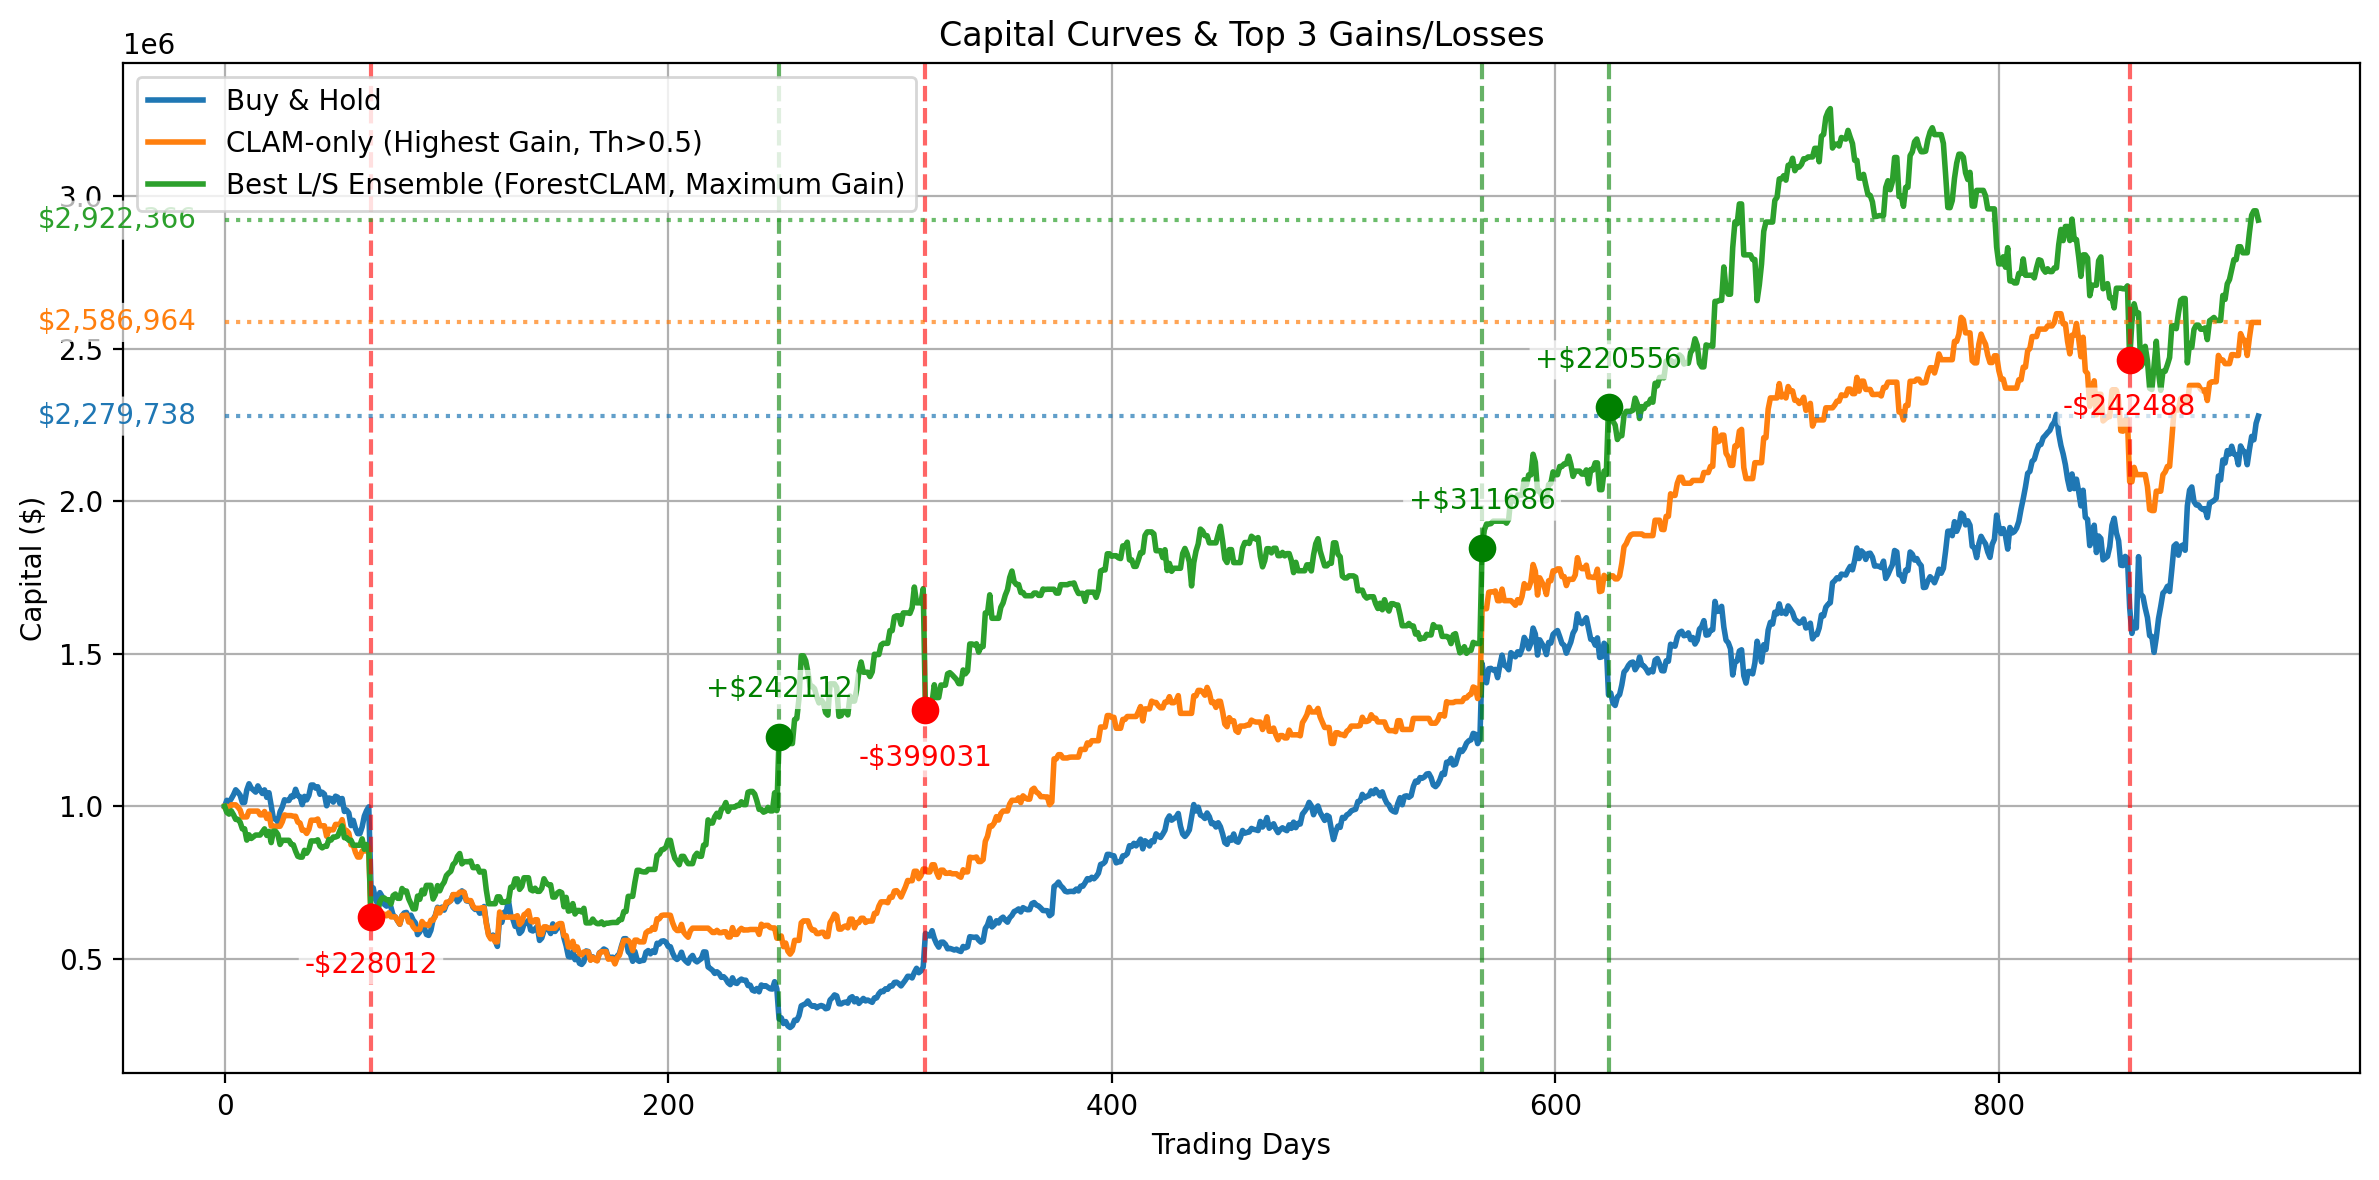

In [19]:
initial_capital = 1_000_000.0

def backtest_long_only(returns, preds, capital):
    masked = np.where(preds == 1, returns, 0.0)
    return np.concatenate([[capital], capital * np.cumprod(1 + masked)])

def backtest_long_short(returns, preds, capital):
    curve = [capital]
    for r, p in zip(returns, preds):
        if p == 1:
            capital *= (1 + r)
        elif p == 0:
            capital *= (1 - r)
        curve.append(capital)
    return np.array(curve)

baseline_curve = np.concatenate((
    [initial_capital],
    initial_capital * np.cumprod(1 + test_returns)
))

cla_conf = probs_cla.max(axis=1).values if hasattr(probs_cla, 'values') else probs_cla.max(axis=1)
cla_preds = np.where(cla_conf > 0.50, np.argmax(probs_cla, axis=1), -1)
cla_preds = np.where(cla_preds == 1, 1, -1)
cla_curve = backtest_long_only(test_returns, cla_preds, initial_capital)

alphas = np.linspace(0, 1, 11)
threshes = np.linspace(0.50, 0.95, 10)
best_cap, best_curve, best_cfg = -np.inf, None, {}

probs_dt = probs

for α_up in alphas:
    for α_down in alphas:
        for thresh in threshes:
            comb = np.zeros_like(probs_cla.numpy())
            comb[:,1] = α_up   * probs_cla[:,1].numpy() + (1-α_up)   * probs_dt[:,1]
            comb[:,0] = α_down * probs_dt[:,0]   + (1-α_down) * probs_cla[:,0].numpy()

            preds = np.argmax(comb, axis=1)
            confs = comb.max(axis=1)
            preds = np.where(confs > thresh, preds, -1)

            curve = backtest_long_short(test_returns, preds, initial_capital)
            if curve[-1] > best_cap:
                best_cap, best_curve = curve[-1], curve
                best_cfg = {"alpha_up":α_up, "alpha_down":α_down, "threshold":thresh}

print(f"Best L/S Ensemble → Final = ${best_cap:,.0f}")

deltas    = best_curve[1:] - best_curve[:-1]
gain_idxs = np.argsort(deltas)[-3:][::-1]
loss_idxs = np.argsort(deltas)[:3]
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
line_bh,  = ax.plot(baseline_curve, label='Buy & Hold',       linewidth=2)
line_cla, = ax.plot(cla_curve,      label='CLAM-only (Highest Gain, Th>0.5)', linewidth=2)
line_best,= ax.plot(best_curve,     label='Best L/S Ensemble (ForestCLAM, Maximum Gain)',   linewidth=2)

for idx, color, dy, va, sign in [
    *( (i, 'green',  12, 'bottom', '+') for i in gain_idxs ),
    *( (i, 'red',   -12, 'top',    '-') for i in loss_idxs )
]:
    day = idx + 1
    y   = best_curve[day]
    ax.scatter(day, y, s=80, zorder=5, color=color)
    ax.axvline(day, linestyle='--', alpha=0.6, color=color)
    ax.annotate(
        f"{sign}${abs(deltas[idx]):.0f}",
        xy=(day, y),
        xytext=(0, dy),
        textcoords='offset points',
        ha='center', va=va,
        color=color,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

last_day = len(baseline_curve) - 1
for line, curve in [(line_bh, baseline_curve),
                    (line_cla, cla_curve),
                    (line_best, best_curve)]:
    y_val = curve[-1]
    color = line.get_color()
    ax.hlines(y=y_val, xmin=0, xmax=last_day,
              colors=color, linestyles='dotted', alpha=0.7)
    ax.annotate(
        f"${y_val:,.0f}",
        xy=(0, y_val),
        xytext=(-10, 0),
        textcoords='offset points',
        ha='right', va='center',
        color=color,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

ax.set_title("Capital Curves & Top 3 Gains/Losses")
ax.set_xlabel("Trading Days")
ax.set_ylabel("Capital ($)")
ax.grid(True)
ax.legend(loc='upper left')

fig.tight_layout()
fig.savefig("capital_curves_final.png", dpi=300, bbox_inches="tight")
plt.show()